In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
class clustering:
    #Script to transform hyperparameters in log file froms string to array in same order. With filter with success at least 3/5 
    def create_data(self, load_location):
        df = pd.read_csv(load_location + '/log.txt', sep='\t', header = None)
        df = df.drop(columns = [0])
        df = df.rename(columns={1: 'Parameters', 2 : 'Score', 3 : 'Total'})

        #Reading "Score" column
        score = []
        for i in range(len(df)):
            score.append(list(np.fromstring(df['Score'][i][1:-1], dtype=float, sep=',')))
        score = np.array(score)
        score = np.int_(score)
        df = df.drop(columns=['Score'])
        df = pd.concat([df, pd.DataFrame(([[k] for k in score]), columns = ['Score'])], axis = 1)

        #Reading "Parameters" column
        parameters = []
        for i in range(len(df)):
            parameters.append(list(np.fromstring(df['Parameters'].iloc[i][2:-2], dtype=float, sep=' ')))
        parameters = np.array(parameters)

        df = df.drop(columns=['Parameters'])
        df = pd.concat([df, pd.DataFrame(([[k] for k in parameters]), columns = ['Parameters'])], axis = 1)

        #Counting success
        success = []
        for i in range(len(df)):
            success.append(np.count_nonzero(df['Score'][i] != 40))
        df = df.assign(Success = success)

        #Selecting data based on success number
        self.data = df.loc[df['Success'] >= 3].reset_index(drop=True)
        
        #Create raw array of parameters column
        self.raw = []
        for i in range(len(self.data)):
            self.raw.append(list(self.data['Parameters'][i]))
        self.raw = np.array(self.raw)
        return self.data
    
    def plot_dendrogram(self, model, ax = None, **kwargs):
        # Create linkage matrix and then plot the dendrogram
        # Create the counts of samples under each node
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count

        linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

        # Plot the corresponding dendrogram
        dendrogram(linkage_matrix, ax=ax, **kwargs)
        return

    def show_dendrogram(self):
        #setting distance_threshold = 0
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
        model = model.fit(self.raw)

        # plot the top three levels of the dendrogram
        plt.figure(figsize=(7, 7), dpi = 300)
        plt.title("Hierarchical Clustering Dendrogram")
        self.plot_dendrogram(model, ax=ax, truncate_mode="level", p=3)
        plt.xlabel("Number of points (or index of point if no parenthesis).")
        plt.ylabel('Distance')
        plt.show()
        return
    
    def show_all_dendrogram(self, load_location):
        #Setting distance_threshold = 0
        for i in range(4):
            self.create_data(load_location[i])
            locals()['raw_' + str(i)] = self.raw
            locals()['model_' + str(i)] = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
            locals()['model_' + str(i)] = locals()['model_' + str(i)].fit(locals()['raw_' + str(i)])

        # Create a grid of subplots
        fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharey= True, dpi=300)

        # Plot each dendrogram in one of the subplots
        for i, ax in enumerate(axes.flatten()):
            ax.text(0.895, 0.92, f'Model {i+1}', horizontalalignment='center', transform=ax.transAxes, fontsize = 8)
            self.plot_dendrogram(locals()['model_' + str(i)], ax=ax, truncate_mode="level", p=2)
            ax.set_ylim(0, 18)
            ax.set_yticks(np.arange(0, 19, 3))
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
        
        plt.text(0.5, -4, 'Number of points', horizontalalignment='center', fontsize = 9)  
        plt.suptitle('Distance', x=0.075, y=0.5, ha = 'center', va='center', rotation=90, fontsize = 9)
        plt.subplots_adjust(wspace=0.07, hspace=0.15)
        plt.show()
        return
    
    def distance_vs_cluster(self, load_location):
        distance = np.linspace(2, 16, 71)
        for i in range(4):
            self.create_data(load_location[i])
            locals()['clusters_number_' + str(i)] = []
            for j in distance:
                model = AgglomerativeClustering(distance_threshold=j, n_clusters=None)
                model = model.fit(self.raw)
                locals()['clusters_number_' + str(i)].append(model.labels_.max()+1)
            locals()['clusters_number_' + str(i)] = np.array(locals()['clusters_number_' + str(i)])
            
        # Create a grid of subplots
        fig = plt.figure(figsize = (3.5, 3), dpi = 300)

        # Plot each dendrogram in one of the subplots
        plt.plot(distance, locals()['clusters_number_' + str(0)], marker = 'o', markersize=2, label = 'HP 1', linewidth=0.5, color = '#cd81b5') #red
        plt.plot(distance, locals()['clusters_number_' + str(1)], marker = 'o', markersize=2, label = 'HP 2', linewidth=0.5, color = '#ffbf4c') #yellow
        plt.plot(distance, locals()['clusters_number_' + str(2)], marker = 'o', markersize=2, label = 'HP 3', linewidth=0.5, color = '#5db25b') #green
        plt.plot(distance, locals()['clusters_number_' + str(3)], marker = 'o', markersize=2, label = 'HP 4', linewidth=0.5, color = '#6eade1') #blue
        plt.legend()
        plt.xticks(np.arange(2, 17, step=2), fontsize = 8)
        plt.yticks(np.arange(0, 25, step=3), fontsize = 8)
        plt.xlabel('Distance', fontsize = 8)
        plt.ylabel('Number of Clusters', fontsize = 8)
        plt.show()
        return
    
    def create_cluster_table(self, load_location, distance_treshold):
        self.data = self.create_data(load_location)      
        #Agglomerative Clustering
        model = AgglomerativeClustering(distance_threshold = distance_treshold, n_clusters = None).fit(self.raw)
        self.data = self.data.assign(Cluster = model.labels_)
        n_clusters = self.data['Cluster'].max() + 1

        #Create cluster table
        center = []
        dev = []
        member = []
        total_score = []
        score_dev = []

        for i in range(n_clusters):
            parameter = self.data[self.data['Cluster']==i]['Parameters'].to_numpy()
            center.append(parameter.mean().round(decimals = 2))
            dev.append(np.std(parameter, axis=0).round(decimals = 2))
            member.append(len(self.data[self.data['Cluster']==i]))
            total_score.append(np.round(self.data[self.data['Cluster']==i]['Total'].mean()/5, decimals=2))
            score_dev.append(np.round(self.data[self.data['Cluster']==i]['Total'].std()/5, decimals=2))

        cluster_table = pd.DataFrame(list(range(0, (n_clusters))), columns = ['Cluster'])
        cluster_table = pd.concat([cluster_table, pd.DataFrame(([[k] for k in center]), columns = ['Center'])], axis = 1)
        cluster_table = pd.concat([cluster_table, pd.DataFrame(([[k] for k in dev]), columns = ['Deviation'])], axis = 1)
        cluster_table = cluster_table.assign(Member = member, Score = total_score, Score_Dev = score_dev)
        cluster_table = cluster_table.sort_values(by='Score')
        cluster_table = cluster_table.drop(columns='Cluster').reset_index(drop = True)
        cluster_table['Cluster'] = list(range(0, n_clusters))
        return cluster_table

In [9]:
def plot_hyperparameter_influence(load_location, best_cluster):
    for j in range(4):
        globals()['cluster_table_' + str(j)] = pd.read_csv(load_location[j] + 'agglomerative_cluster_table.txt', sep='\t')
        globals()['cluster_table_' + str(j)] = globals()['cluster_table_' + str(j)].drop(globals()['cluster_table_' + str(j)].columns[0], axis=1)
        #Reading "center" column
        globals()['center_' + str(j)] = []
        for i in range(len(globals()['cluster_table_' + str(j)])):
            globals()['center_' + str(j)].append(list(np.fromstring(globals()['cluster_table_' + str(j)]['Center'].iloc[i][1:-1], dtype=float, sep=' ')))
        globals()['center_' + str(j)] = np.array(globals()['center_' + str(j)])

        #Normalise the value
        globals()['center_' + str(j)][:,1:6] = globals()['center_' + str(j)][:,1:6]/2
        globals()['center_' + str(j)][:,9] = globals()['center_' + str(j)][:,9]/0.5

        #Reading "dev" column
        globals()['dev_' + str(j)] = []
        for i in range(len(globals()['cluster_table_' + str(j)])):
            globals()['dev_' + str(j)].append(list(np.fromstring(globals()['cluster_table_' + str(j)]['Deviation'].iloc[i][1:-1], dtype=float, sep=' ')))
        globals()['dev_' + str(j)] = np.array(globals()['dev_' + str(j)])
        #Normalise the value
        globals()['dev_' + str(j)][:,1:6] = globals()['dev_' + str(j)][:,1:6]/2/2
        globals()['dev_' + str(j)][:,9] = globals()['dev_' + str(j)][:,9]/0.5/2
    
    #Plotting
    width = 0.2  # the width of the bars
    legend = ['HP 1', 'HP 2','HP 3', 'HP 4']
    color = ['red', 'orange', 'green', 'blue', 'black']
    color = ['#cd81b5', '#ffbf4c', '#5db25b', '#6eade1', '#e1e1e1']

    fig, axs = plt.subplots(ncols=3, nrows = 1, figsize=(7, 3.5), sharey = True, dpi = 300)

    #Positive Learning
    ax = axs[0]
    labels = [r'$\phi_{damp}$', r'$\phi_{b}$', r'$\phi_{h}$', r'$\phi_{g}$']
    x = np.arange(len(labels))  # the label locations

    #center_0[cluster_entry][hyperparameters]
    rects1 = ax.bar(x - 3/2*width, center_0[best_cluster[0]][0:4], width, yerr = dev_0[best_cluster[0]][0:4], label = str(legend[0]), color = color[0], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects2 = ax.bar(x - 1/2*width, center_1[best_cluster[1]][0:4], width, yerr = dev_1[best_cluster[1]][0:4], label = str(legend[1]), color = color[1], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects3 = ax.bar(x + 1/2*width, center_2[best_cluster[2]][0:4], width, yerr = dev_2[best_cluster[2]][0:4], label = str(legend[2]), color = color[2], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects4 = ax.bar(x + 3/2*width, center_3[best_cluster[3]][0:4], width, yerr = dev_3[best_cluster[3]][0:4], label = str(legend[3]), color = color[3], error_kw=dict(lw=1, capsize=2, capthick=1))

    # Add some text for labels, title and custom x-axis tick labels, etc.

    ax.set_title('Positive Learning', fontsize = 11)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize = 10)
    ax.set_ylabel('Value (normalized by max)', fontsize = 11)



    #Negative Learning
    ax = axs[1]
    labels = [r'$\bar\phi_{b}$', r'$\bar\phi_{h}$', r'$\bar\phi_{g}$']
    x = np.arange(len(labels))  # the label locations

    rects1 = ax.bar(x - 3/2*width, center_0[best_cluster[0]][4:7], width, yerr = dev_0[best_cluster[0]][4:7], label = str(legend[0]), color = color[0], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects2 = ax.bar(x - 1/2*width, center_1[best_cluster[1]][4:7], width, yerr = dev_1[best_cluster[1]][4:7], label = str(legend[1]), color = color[1], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects3 = ax.bar(x + 1/2*width, center_2[best_cluster[2]][4:7], width, yerr = dev_2[best_cluster[2]][4:7], label = str(legend[2]), color = color[2], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects4 = ax.bar(x + 3/2*width, center_3[best_cluster[3]][4:7], width, yerr = dev_3[best_cluster[3]][4:7], label = str(legend[3]), color = color[3], error_kw=dict(lw=1, capsize=2, capthick=1))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title('Negative Learning', fontsize = 11)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize = 10)



    #Mutation Learning
    ax = axs[2]
    labels = [r'$\rho_{1}$', r'$\rho_{2}$', r'$\itr$']
    x = np.arange(len(labels))  # the label locations

    rects1 = ax.bar(x - 3/2*width, center_0[best_cluster[0]][7:10], width, yerr = dev_0[best_cluster[0]][7:10], label = str(legend[0]), color = color[0], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects2 = ax.bar(x - 1/2*width, center_1[best_cluster[1]][7:10], width, yerr = dev_1[best_cluster[1]][7:10], label = str(legend[1]), color = color[1], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects3 = ax.bar(x + 1/2*width, center_2[best_cluster[2]][7:10], width, yerr = dev_2[best_cluster[2]][7:10], label = str(legend[2]), color = color[2], error_kw=dict(lw=1, capsize=2, capthick=1))
    rects4 = ax.bar(x + 3/2*width, center_3[best_cluster[3]][7:10], width, yerr = dev_3[best_cluster[3]][7:10], label = str(legend[3]), color = color[3], error_kw=dict(lw=1, capsize=2, capthick=1))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title('Mutation', fontsize = 11)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize = 10)

    """plt.suptitle('Value (a.u.)', x = 0.01, y= 0.5, fontsize = 11, rotation = 90)"""
    plt.rc('ytick', labelsize=10)
    plt.rc('xtick', labelsize=10)
    plt.legend(bbox_to_anchor=(0.6, -0.1), ncol = 4)
    plt.subplots_adjust(wspace=0.1)

    plt.show()
    return


In [4]:
#load in all data
load_location = ['../raw_data/parameters_optimization/model1/', 
                 '../raw_data/parameters_optimization/model2/',
                 '../raw_data/parameters_optimization/model3/',
                 '../raw_data/parameters_optimization/model4/']
best_cluster = [0, 0, 0, 0]
best_distance = [5.4, 5.2, 4.2, 3]
best_distance = [6, 6, 6, 6]  #new distance determined

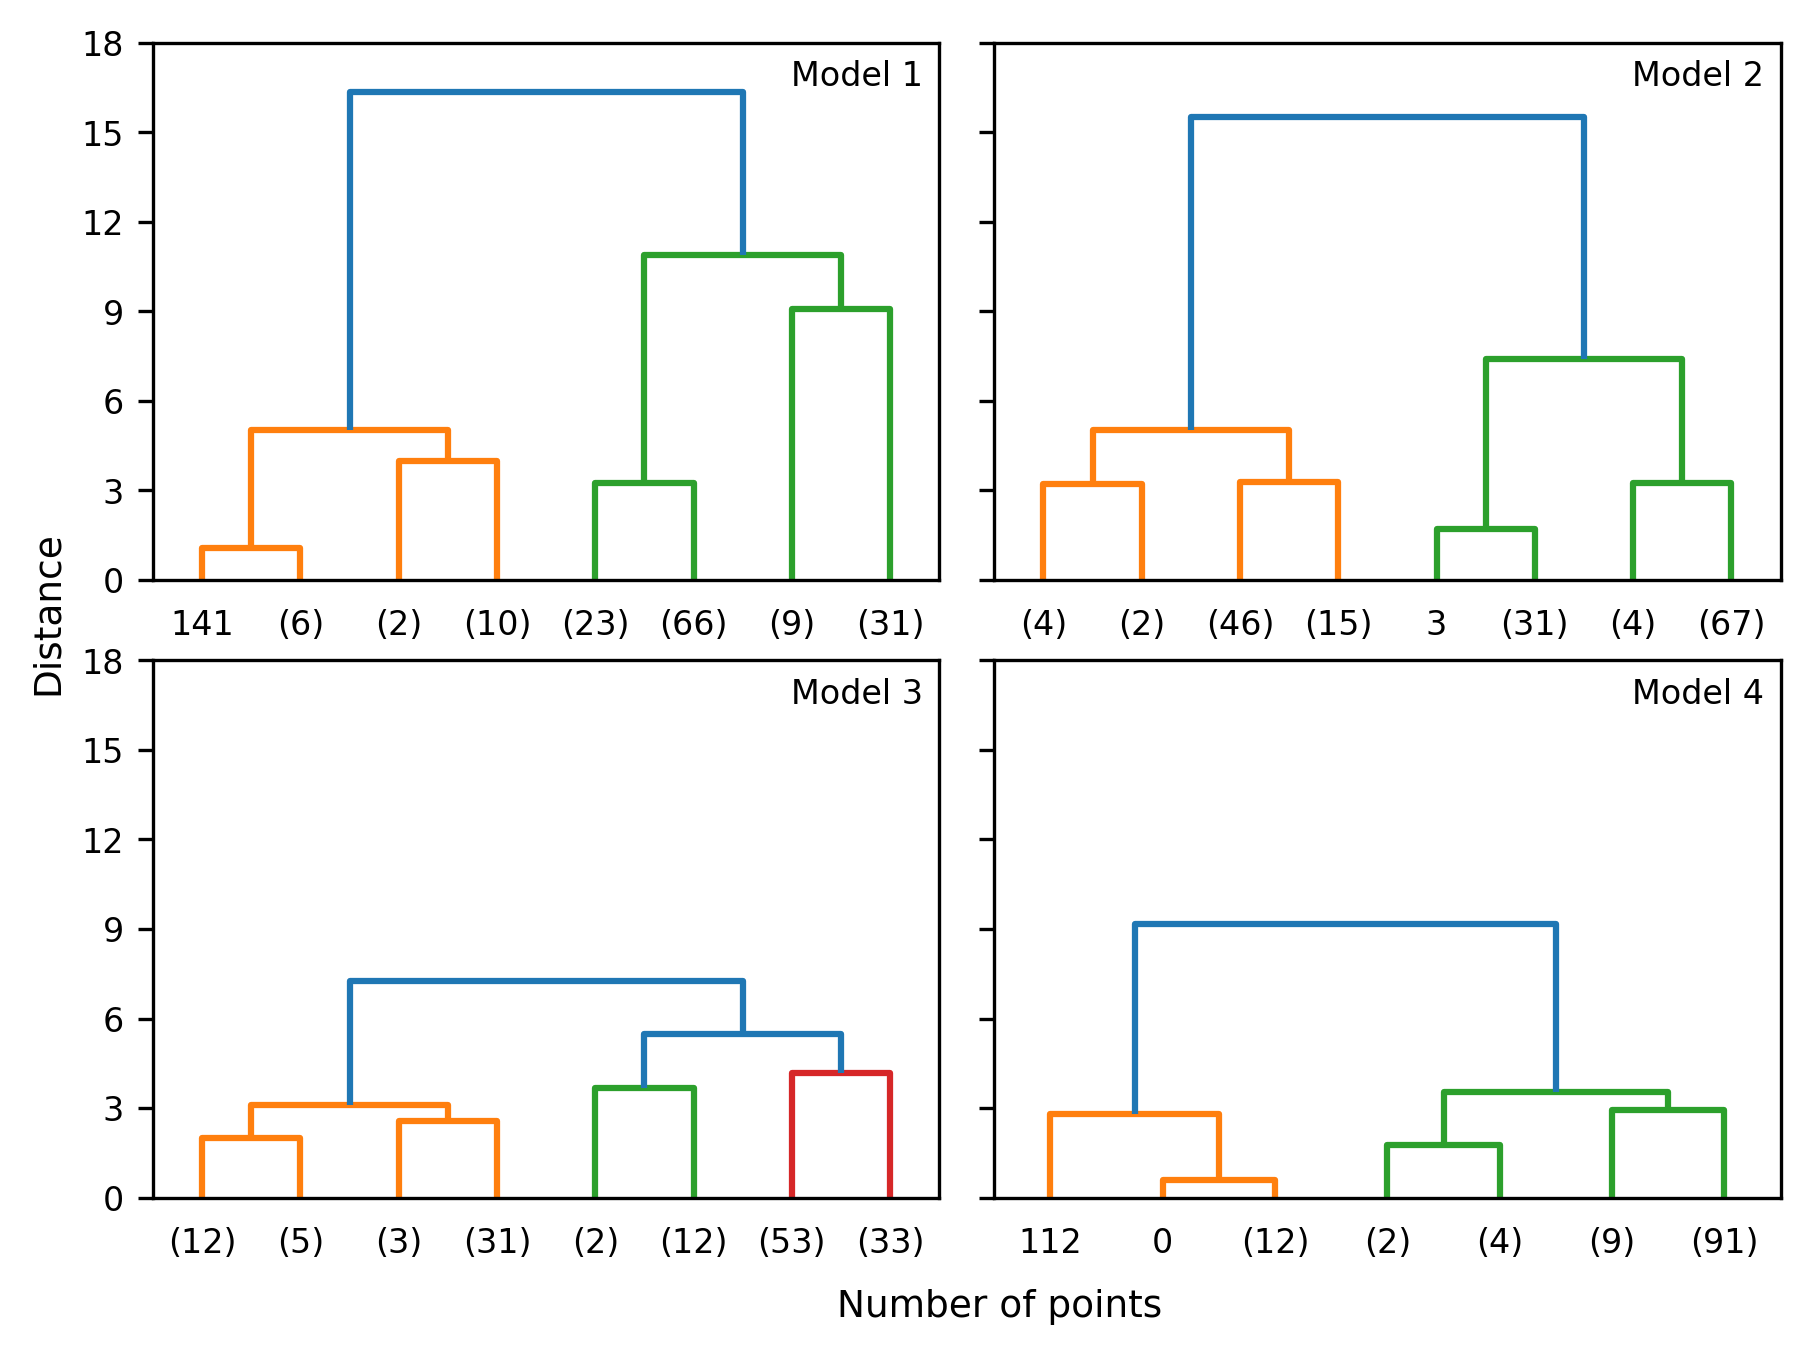

In [5]:
clustering().show_all_dendrogram(load_location)

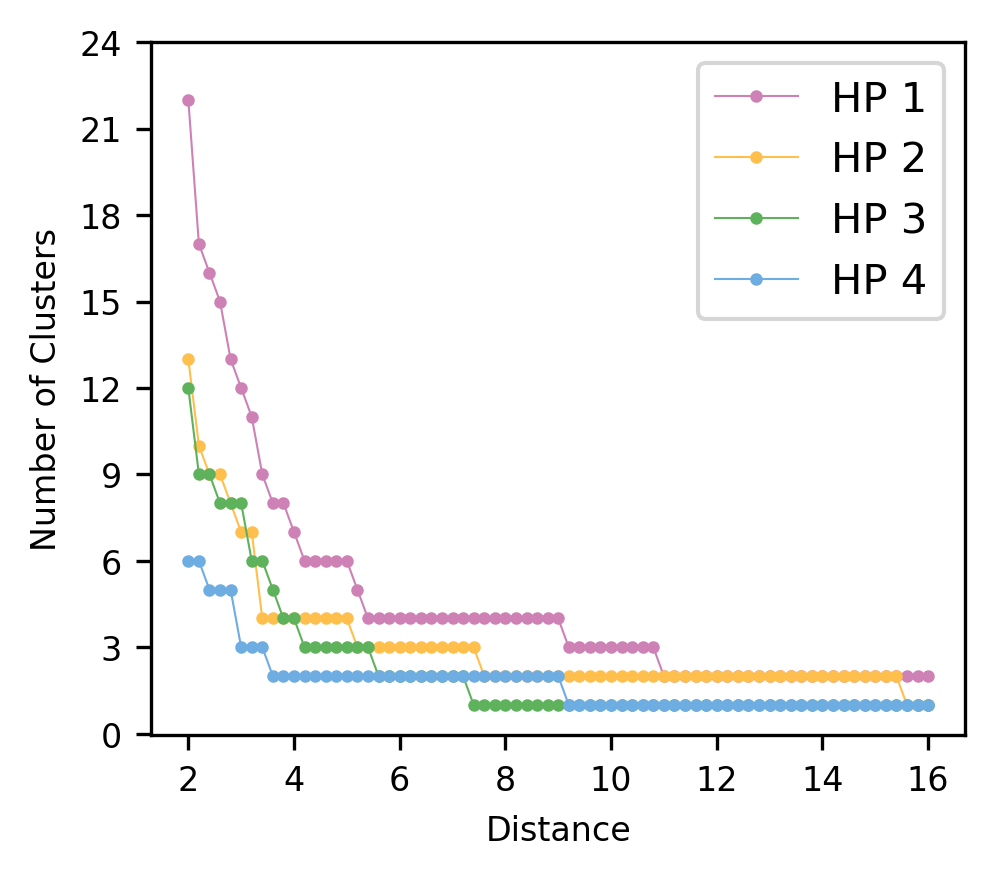

In [6]:
clustering().distance_vs_cluster(load_location)

In [7]:
for i in range(4):
    clustering().create_cluster_table(load_location[i], best_distance[i]).to_csv(load_location[i] + '/agglomerative_cluster_table.txt', sep='\t', index=True, mode='w')

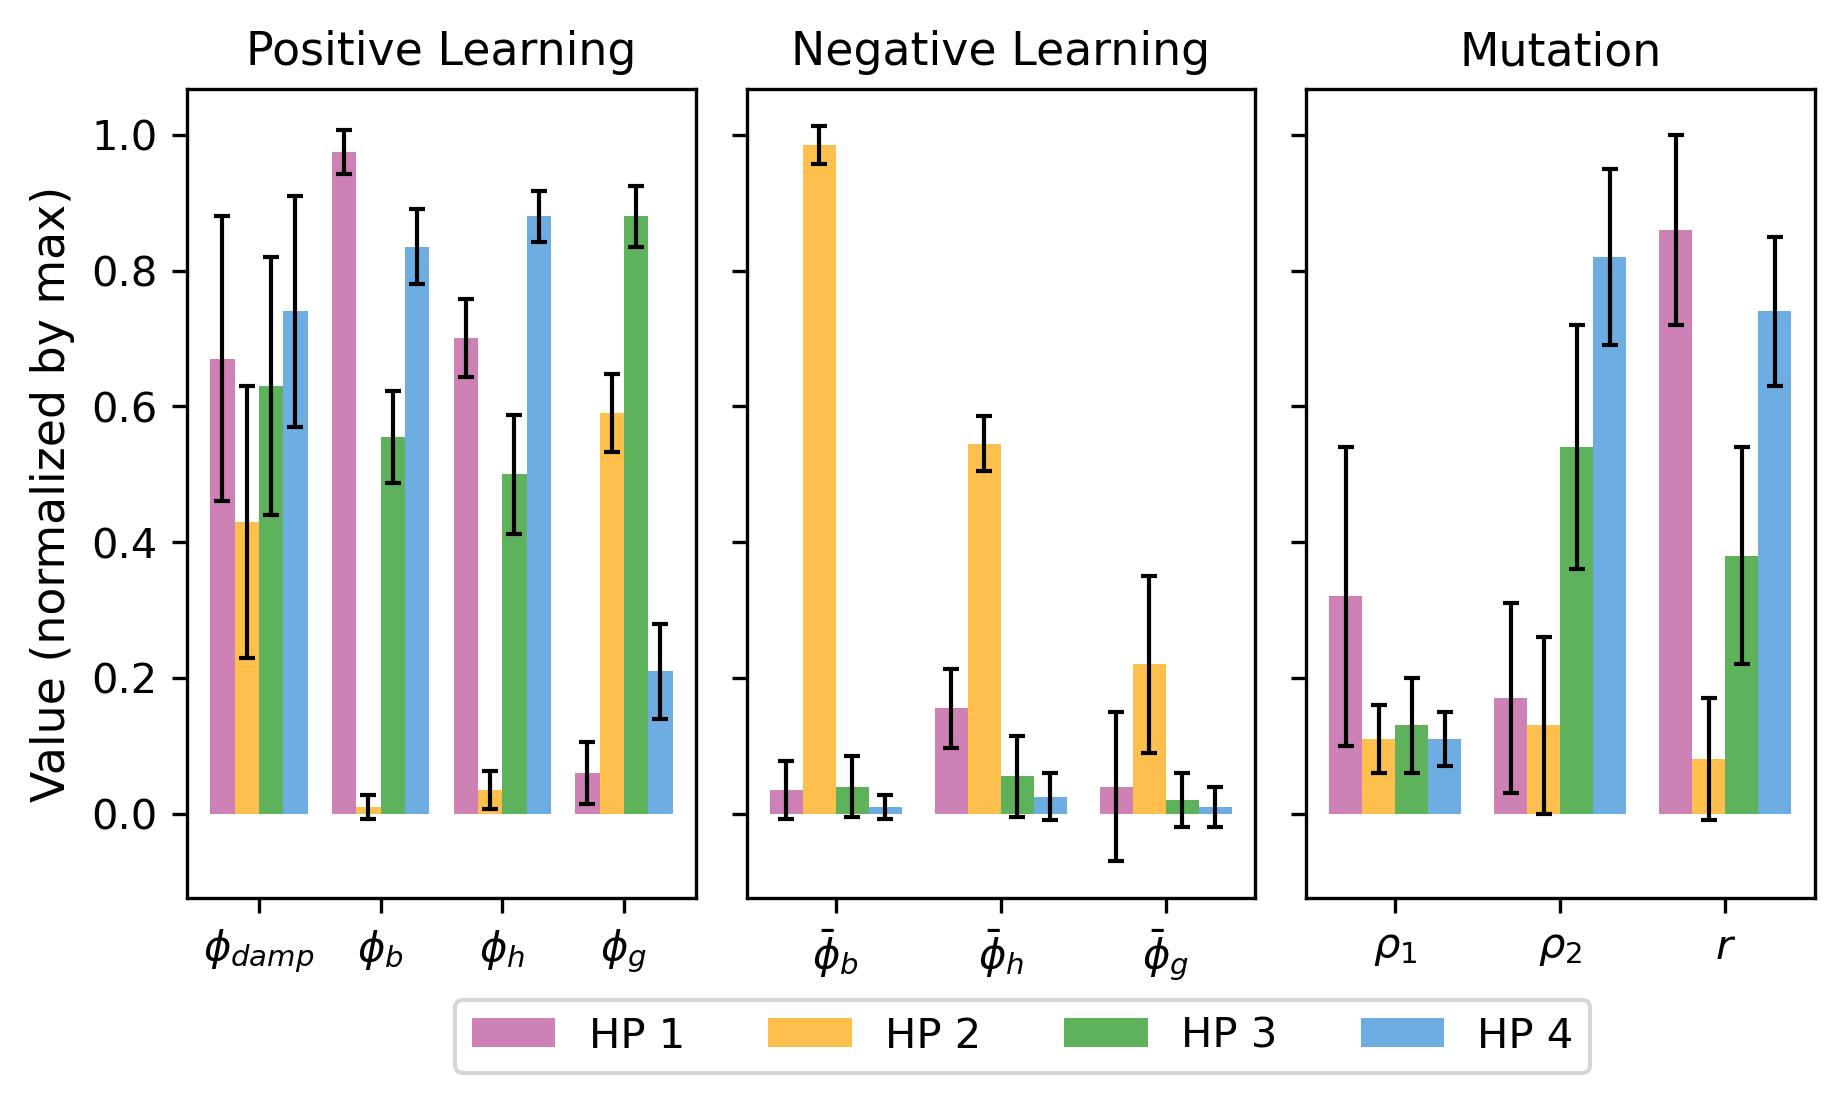

In [10]:
plot_hyperparameter_influence(load_location, best_cluster)

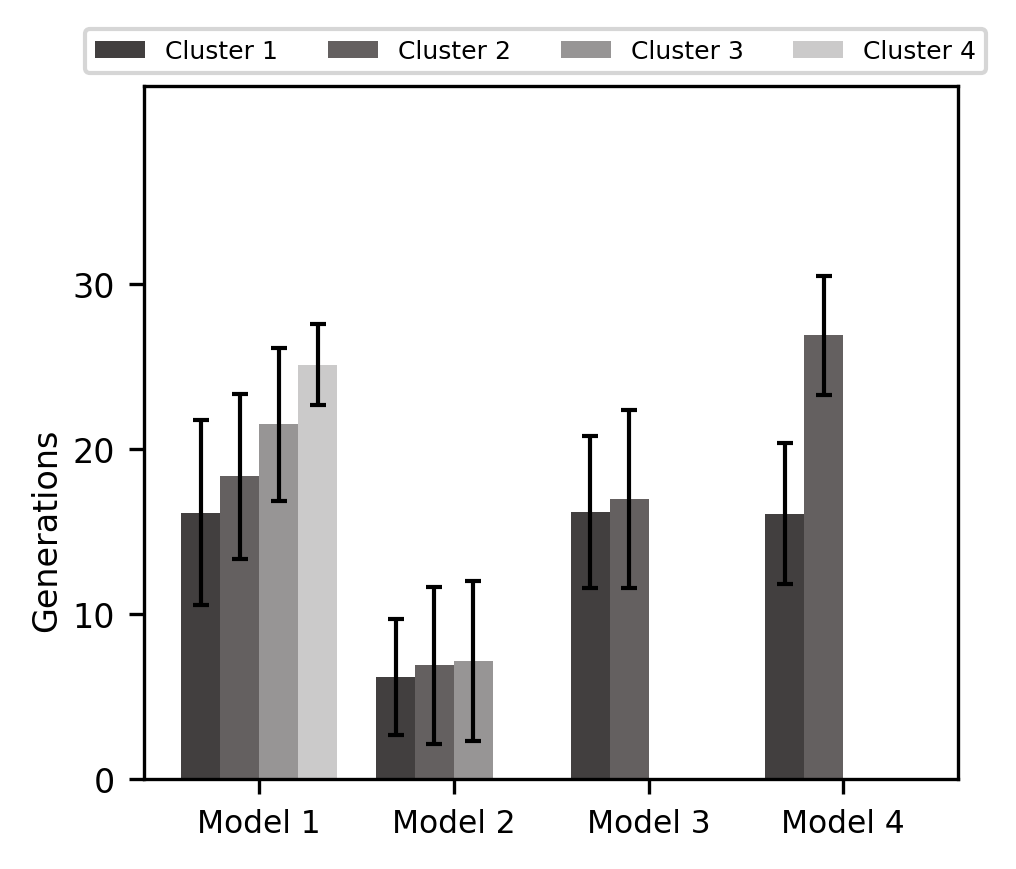

In [11]:
model = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

#Number of Generations to reach optima
score = []
for i in range(4):
    score.append(locals()['cluster_table_' + str(i)]['Score'].to_list())
#Modify the data with 0 and transpose
max_length = max(len(sublist) for sublist in score)
# Pad sublists with zeros
score = [sublist + [-1] * (max_length - len(sublist)) for sublist in score]
score = np.array(score)
score = score.transpose()

dev = []
for i in range(4):
    dev.append(locals()['cluster_table_' + str(i)]['Score_Dev'].to_list())
#Modify the data with 0 and transpose
max_length = max(len(sublist) for sublist in dev)
# Pad sublists with zeros
dev = [sublist + [0] * (max_length - len(sublist)) for sublist in dev]
dev = np.array(dev)
dev = dev.transpose()



# Width of each bar
bar_width = 0.2
index = np.arange(4)

# Create bar plot with error bars and caps
plt.figure(figsize=(3.5, 3), dpi = 300)
plt.bar(index - 1.5 * bar_width, score[0], width=bar_width, yerr=dev[0], error_kw=dict(lw=1, capsize=2, capthick=1), label = 'Cluster 1', color = '#423f3f')
plt.bar(index - 0.5 * bar_width, score[1], width=bar_width, yerr=dev[1], error_kw=dict(lw=1, capsize=2, capthick=1), label = 'Cluster 2', color = '#646060')
plt.bar(index + 0.5 * bar_width, score[2], width=bar_width, yerr=dev[2], error_kw=dict(lw=1, capsize=2, capthick=1), label = 'Cluster 3', color = '#979595')
plt.bar(index + 1.5 * bar_width, score[3], width=bar_width, yerr=dev[3], error_kw=dict(lw=1, capsize=2, capthick=1), label = 'Cluster 4', color = '#cbcaca')

# Adding labels and title
"""plt.title('Generations to Reach Optima', fontsize = 9)"""
plt.legend(bbox_to_anchor=(1.05, 1.1), ncol = 4, fontsize = 6)
plt.ylabel('Generations', fontsize = 8)
plt.gca().yaxis.set_label_coords(-0.1, 0.36)
plt.xticks(index, model, fontsize = 7.5)
plt.ylim(0, 42)
plt.yticks((0, 10, 20, 30), fontsize = 8)

# Show plot
plt.show()

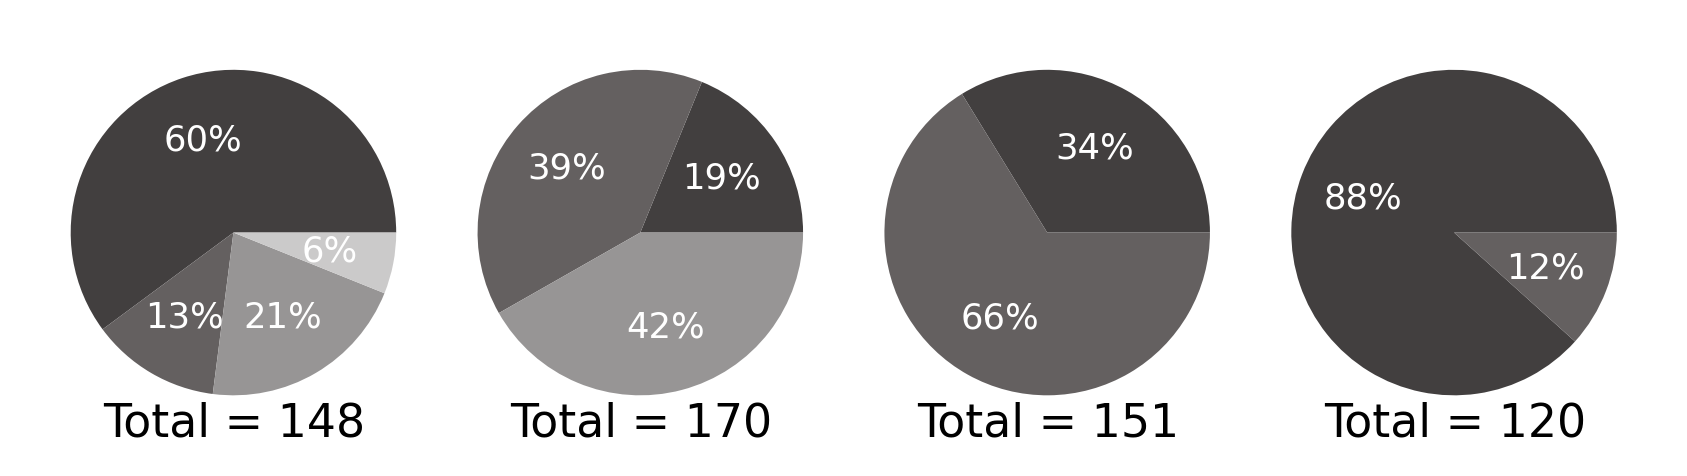

In [12]:
#Pie Chart
member = []
for i in range(4):
    member.append(locals()['cluster_table_' + str(i)]['Member'].to_list())
#Modify the data with 0 and transpose
max_length = max(len(sublist) for sublist in member)
# Pad sublists with zeros
member = [sublist + [0] * (max_length - len(sublist)) for sublist in member]
member = np.array(member)

sizes = []
for i in range(4):
    sizes.append(member[i].sum())

#Colors for each category
colors = ['#423f3f', '#646060', '#979595', '#cbcaca']

#Create subplots for four pie charts in a single row
fig, axs = plt.subplots(1, 4, figsize=(7, 3), dpi = 300)

#Plot each pie chart
for i in range(len(member)):
    # Filter out zero values
    filtered_member = member[i][member[i] != 0]
    
    axs[i].pie(filtered_member, colors=colors, autopct='%1.f%%', textprops={'size': '8.5', 'color': 'white'})
    """axs[i].set_title(f'Model {i+1}')"""
    axs[i].text(-0.8, -1.25, 'Total = ' + str(sizes[i]), fontsize=11)

#Adjust layout
plt.subplots_adjust(wspace=0)

#Show plot
plt.show()